In [3]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
# from tqdm import tqdm_notebook, tnrange
# from glob import glob
# from itertools import chain
from skimage.io import imread, imshow
# , concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
# Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
DataPath = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [6]:
len(images), len(masks)

(3929, 3929)

In [7]:
df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})

In [8]:
df.head()

directory                        images  \
0  TCGA_DU_7010_19860307  TCGA_DU_7010_19860307_56.tif   
1  TCGA_DU_7010_19860307   TCGA_DU_7010_19860307_8.tif   
2  TCGA_DU_7010_19860307  TCGA_DU_7010_19860307_34.tif   
3  TCGA_DU_7010_19860307  TCGA_DU_7010_19860307_33.tif   
4  TCGA_DU_7010_19860307  TCGA_DU_7010_19860307_43.tif   

                               masks  
0  TCGA_DU_7010_19860307_56_mask.tif  
1   TCGA_DU_7010_19860307_8_mask.tif  
2  TCGA_DU_7010_19860307_34_mask.tif  
3  TCGA_DU_7010_19860307_33_mask.tif  
4  TCGA_DU_7010_19860307_43_mask.tif

In [9]:
def print_imShape():
    idx = np.random.randint(0, len(df))
    
    imagePath = os.path.join(DataPath, df['directory'].iloc[idx], df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, df['directory'].iloc[idx], df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    print(image.shape, mask.shape)

In [10]:
print_imShape()

(256, 256, 3) (256, 256, 3)


In [11]:
def plot_images():
    idx = np.random.randint(0, len(df))
    
    imagePath = os.path.join(DataPath, df['directory'].iloc[idx], df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, df['directory'].iloc[idx], df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.5)
    axs[2].set_title('MRI with mask')
    
#     plt.grid(False)
    plt.show()

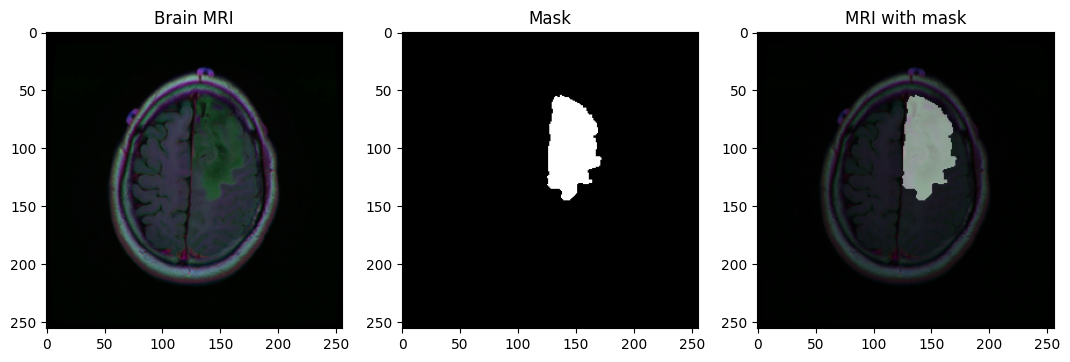

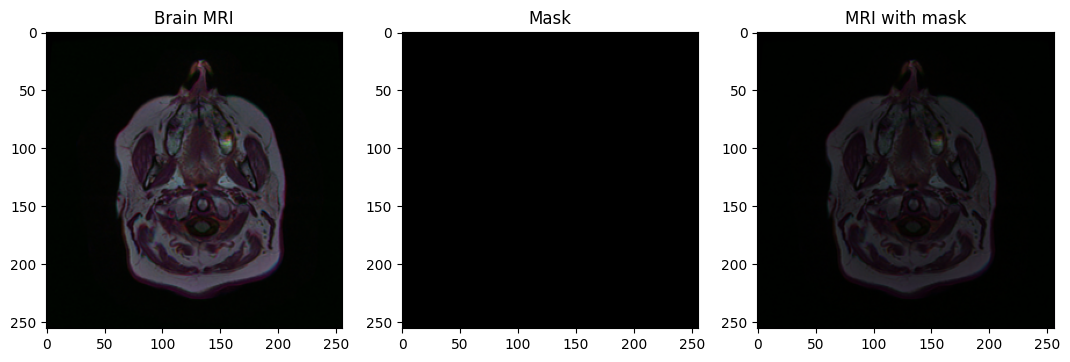

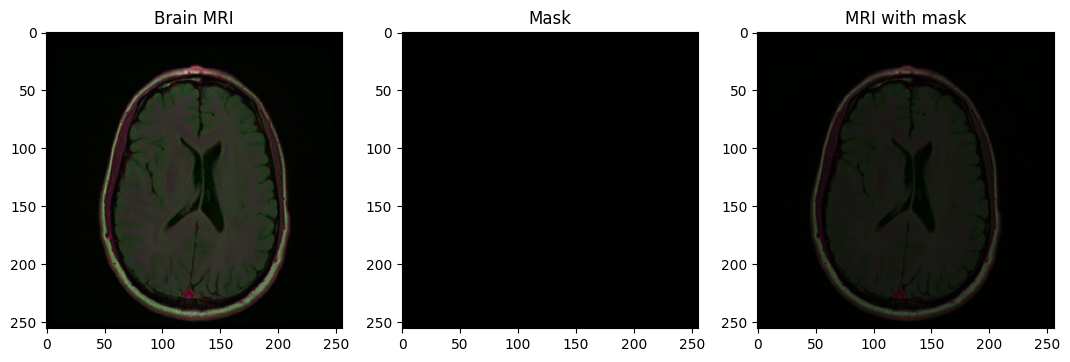

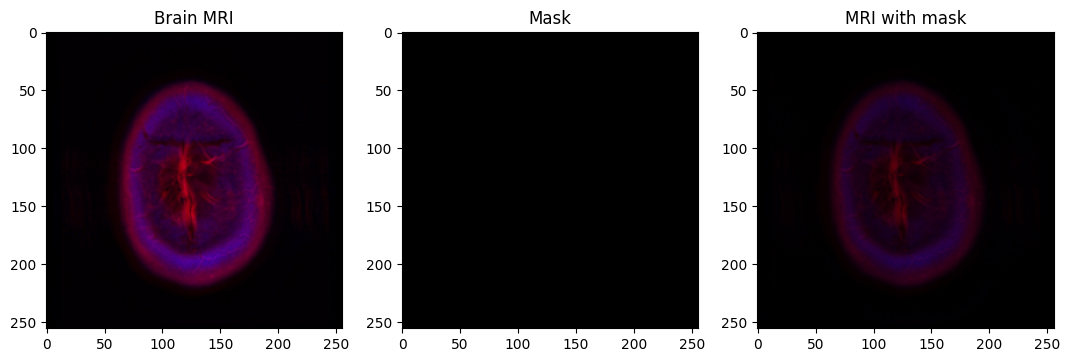

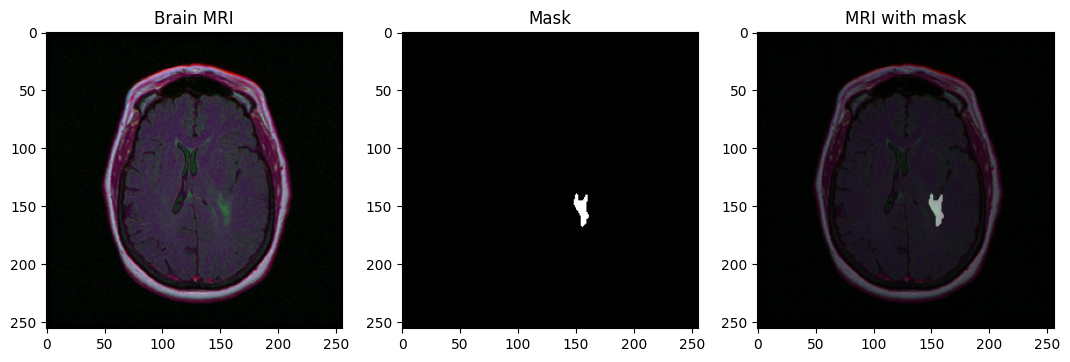

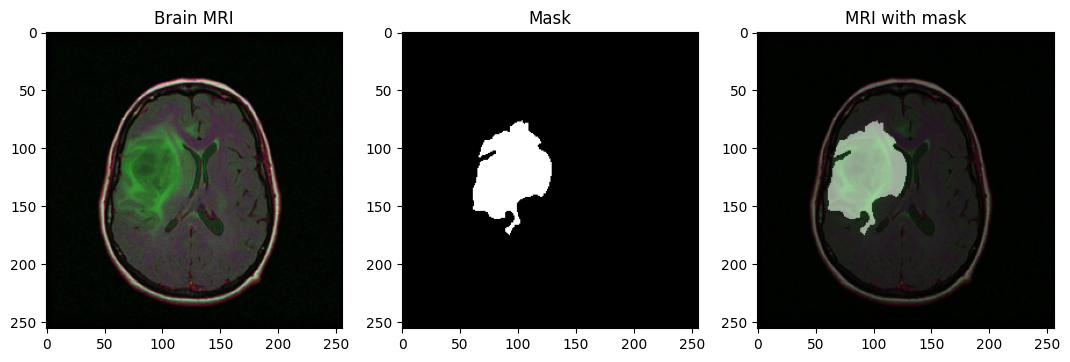

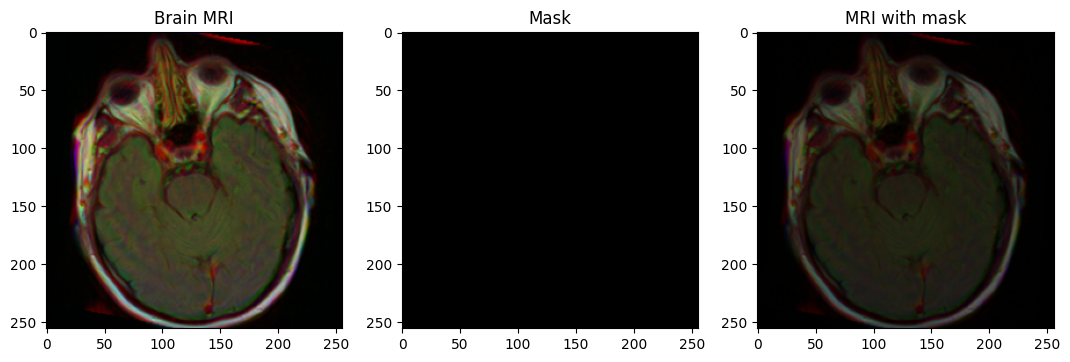

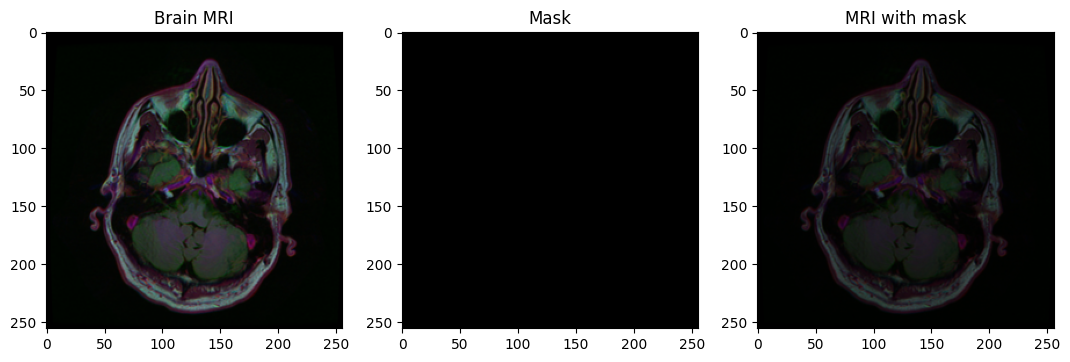

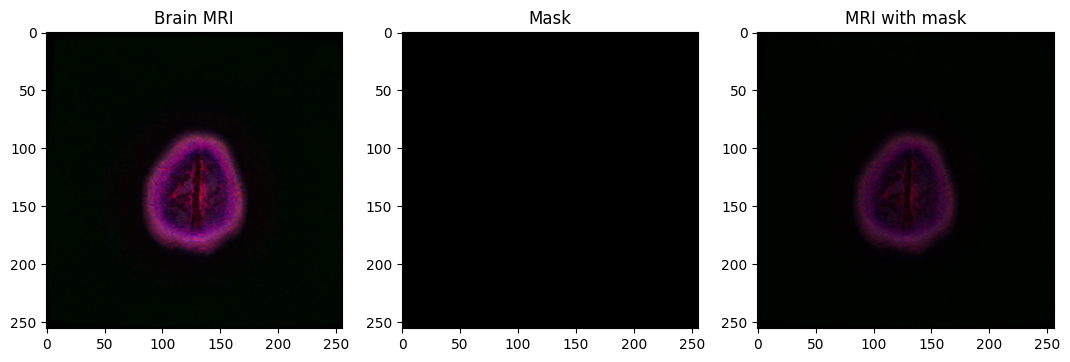

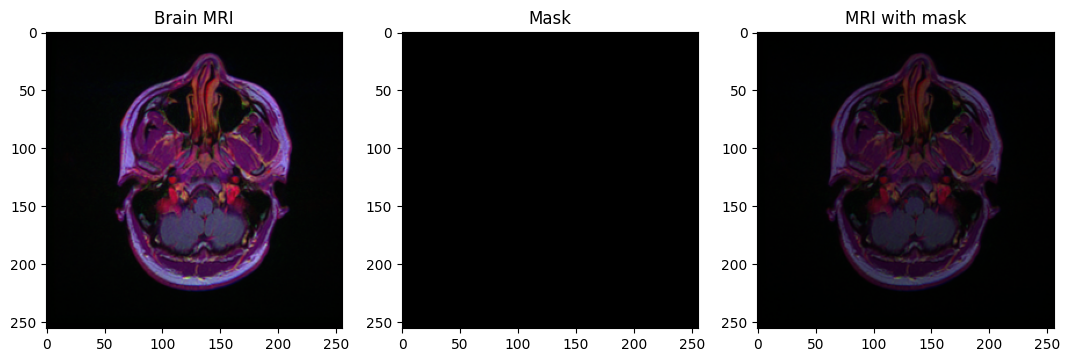

In [42]:
for i in range(10):
    plot_images()

In [13]:
df['image-path'] = DataPath + df['directory'] + '/' + df['images']
df['mask-path'] = DataPath + df['directory'] + '/' + df['masks'] 

In [14]:
train, test = train_test_split(df, test_size=0.5, random_state=42)

In [15]:
EPOCHS = 25
BATCH_SIZE = 32
ImgHieght = 256
ImgWidth = 256
Channels = 3

In [16]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [17]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')    

Found 1964 validated image filenames.
Found 1964 validated image filenames.


In [18]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
vimage_generator=imagegen.flow_from_dataframe(dataframe=test,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation data generator
vmask_generator=maskgen.flow_from_dataframe(dataframe=test,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')    

Found 1965 validated image filenames.
Found 1965 validated image filenames.


In [19]:
def data_iterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [20]:
train_gen = data_iterator(timage_generator, tmask_generator)
valid_gen = data_iterator(vimage_generator, vmask_generator)

In [21]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)

In [22]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(iou_coef)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(dice_coef)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    
    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'
    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
# Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

In [23]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [24]:
def unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [25]:
input_img = Input((ImgHieght, ImgWidth, 3), name='img')
model = unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [27]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-4, verbose=1),
    ModelCheckpoint('model-brain-mri.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [28]:
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE

In [29]:
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)


Epoch 1/25


2023-10-23 22:05:27.838666: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/61 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.8319
Epoch 1: val_loss improved from inf to 0.49460, saving model to model-brain-mri.h5
61/61 [==============================] - 126s 2s/step - loss: 0.5289 - accuracy: 0.8319 - val_loss: 0.4946 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 2/25
62/61 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.9889
Epoch 2: val_loss improved from 0.49460 to 0.30509, saving model to model-brain-mri.h5
61/61 [==============================] - 58s 950ms/step - loss: 0.2614 - accuracy: 0.9889 - val_loss: 0.3051 - val_accuracy: 0.9891 - lr: 0.0010
Epoch 3/25
62/61 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9914
Epoch 3: val_loss improved from 0.30509 to 0.19027, saving model to model-brain-mri.h5
61/61 [==============================] - 57s 937ms/step - loss: 0.1785 - accuracy: 0.9914 - val_loss: 0.1903 - val_accuracy: 0.9892 - lr: 0.0010
Epoch 4/25
62/61 [=====================

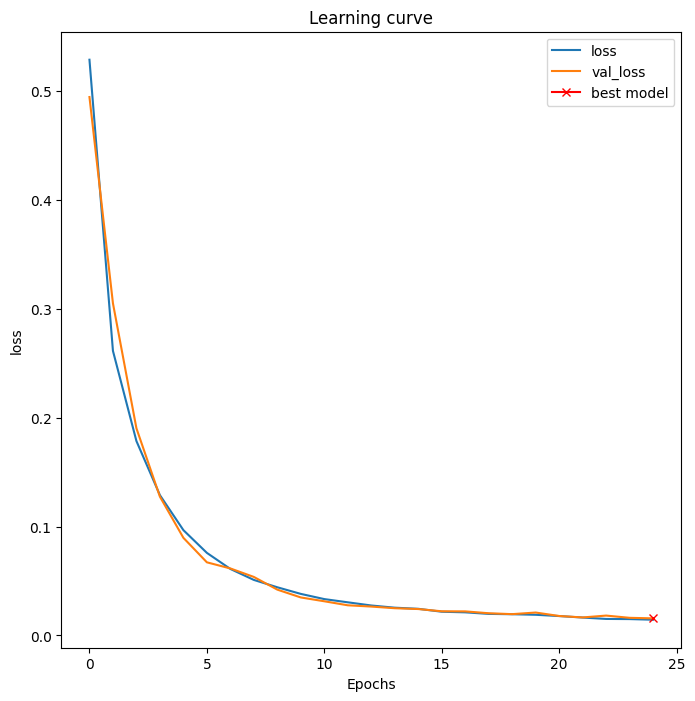

In [30]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
# plt.plot(results.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results.history["loss"], label="loss")
# plt.plot(results.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
# plt.grid(False)
plt.show()

# Prediction

In [46]:
# load the best model
model.load_weights('model-brain-mri.h5')

In [32]:
eval_results = model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

61/61 [==============================] - 11s 174ms/step - loss: 0.0153 - accuracy: 0.9958


1/1 [==============================] - 1s 787ms/step


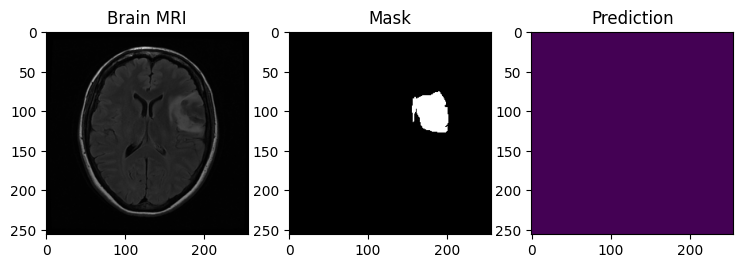

1/1 [==============================] - 0s 27ms/step


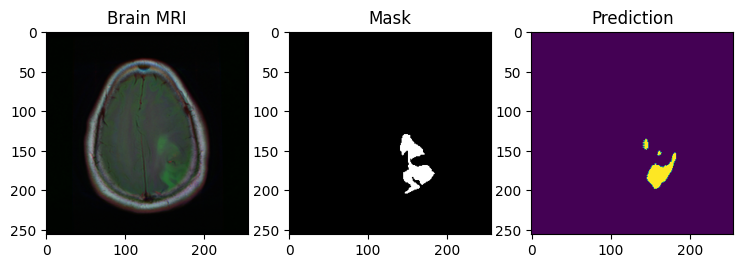

1/1 [==============================] - 0s 23ms/step


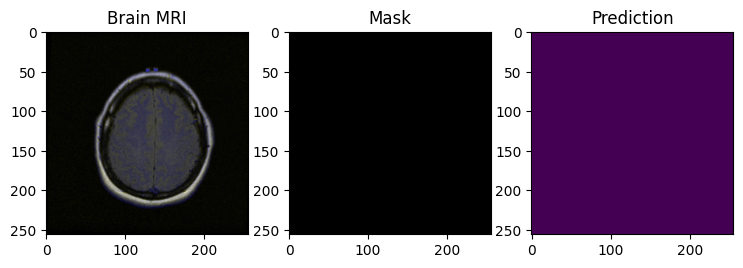

1/1 [==============================] - 0s 25ms/step


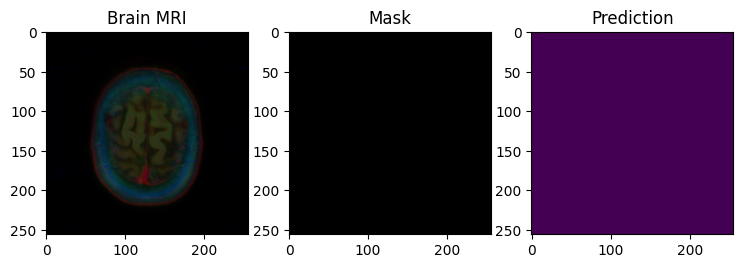

1/1 [==============================] - 0s 26ms/step


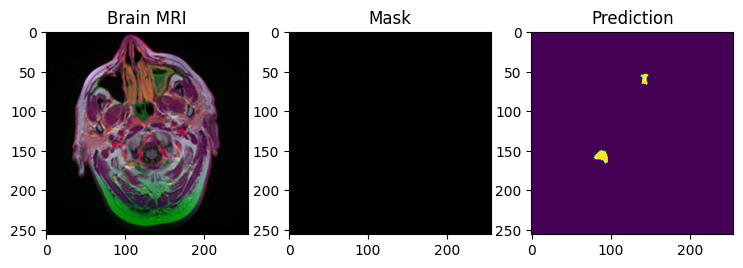

1/1 [==============================] - 0s 26ms/step


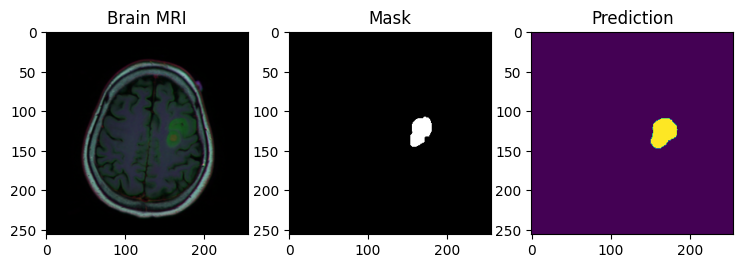

1/1 [==============================] - 0s 26ms/step


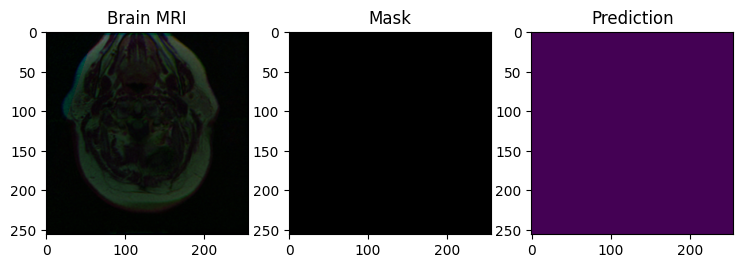

1/1 [==============================] - 0s 24ms/step


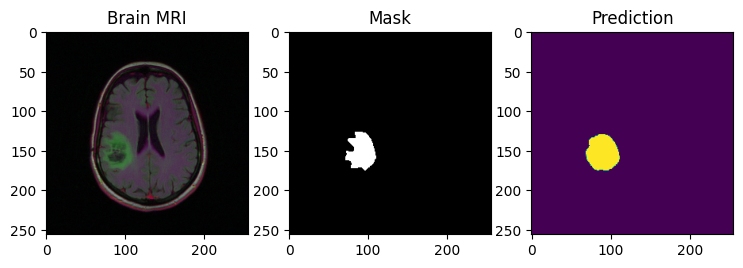

1/1 [==============================] - 0s 24ms/step


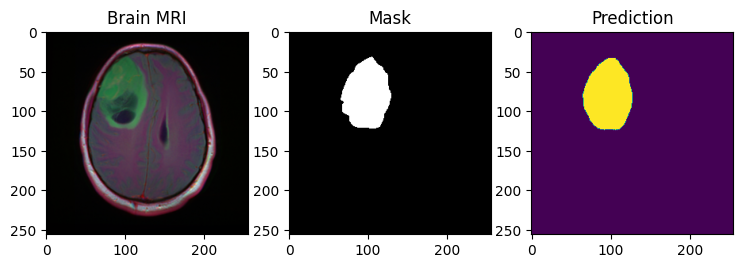

1/1 [==============================] - 0s 24ms/step


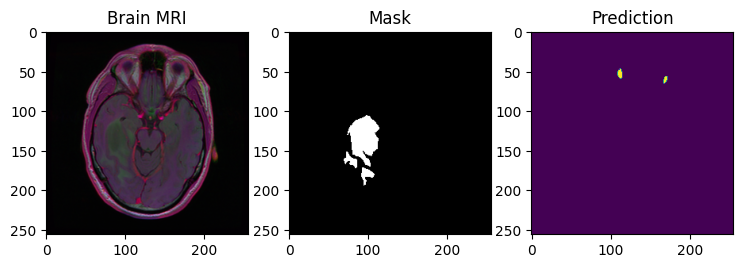

1/1 [==============================] - 0s 26ms/step


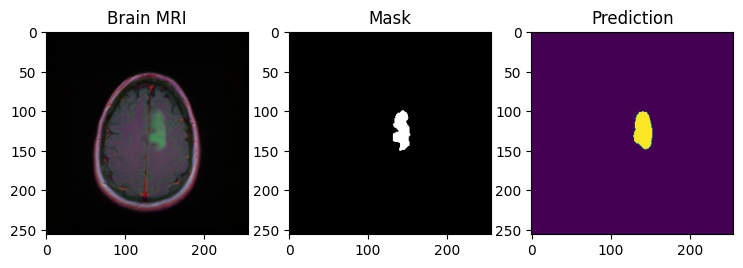

1/1 [==============================] - 0s 24ms/step


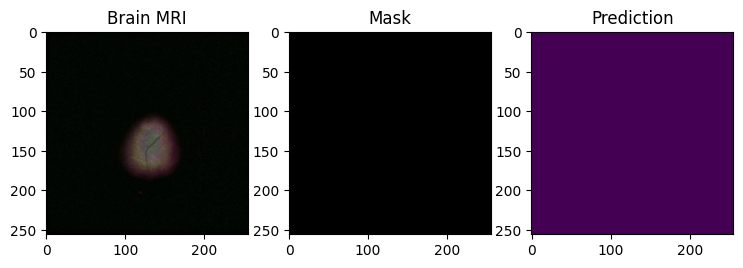

1/1 [==============================] - 0s 24ms/step


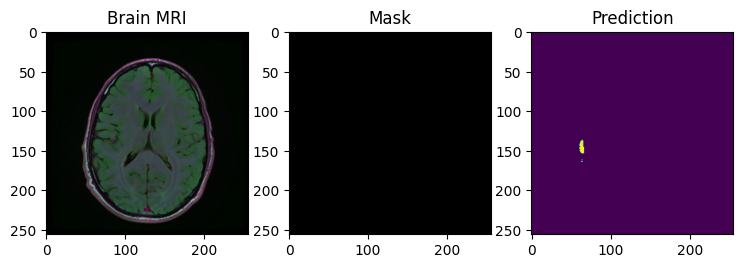

1/1 [==============================] - 0s 25ms/step


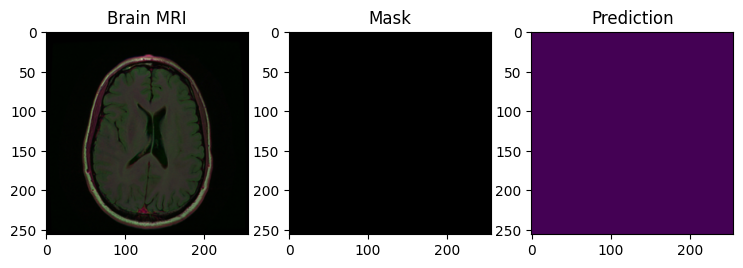

1/1 [==============================] - 0s 24ms/step


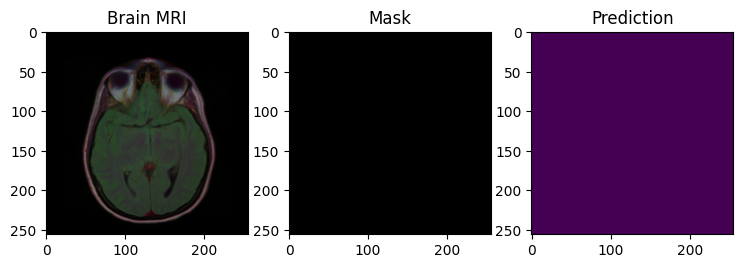

1/1 [==============================] - 0s 26ms/step


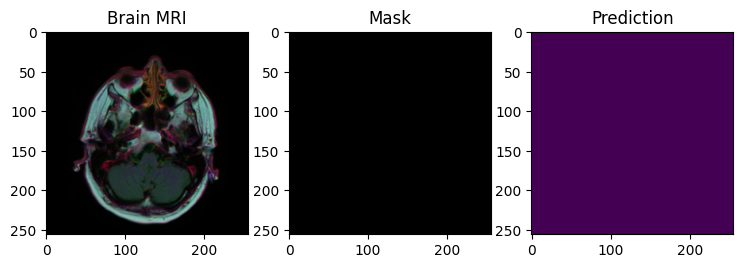

1/1 [==============================] - 0s 23ms/step


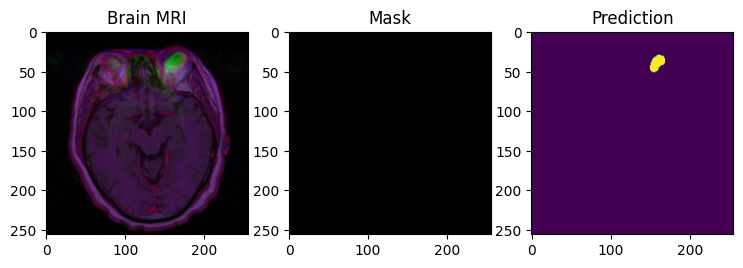

1/1 [==============================] - 0s 23ms/step


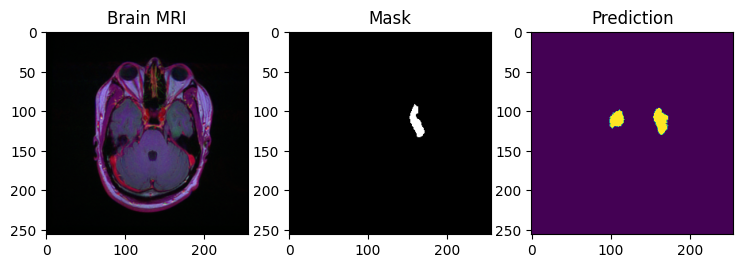

1/1 [==============================] - 0s 24ms/step


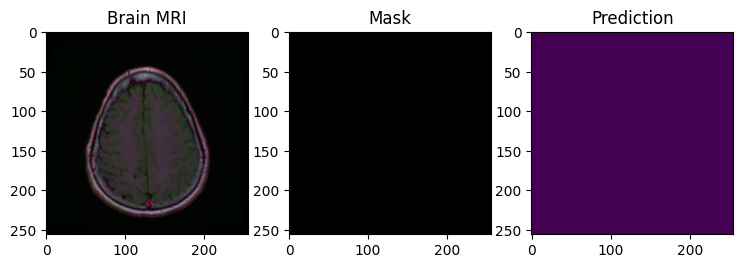

1/1 [==============================] - 0s 24ms/step


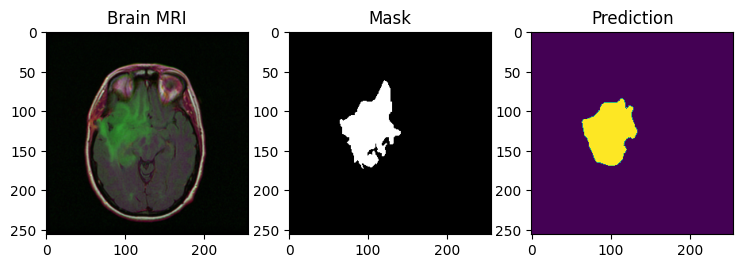

In [33]:
for i in range(20):
    idx = np.random.randint(0, len(df))
    
    imagePath = os.path.join(DataPath, df['directory'].iloc[idx], df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, df['directory'].iloc[idx], df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image ,(ImgHieght, ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Brain MRI')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('Prediction')
    plt.show()

# Dice loss

In [34]:
model = unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss= dice_loss, metrics= [dice_coef])
# model.summary()

In [35]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-4, verbose=1),
    ModelCheckpoint('model-brain-mri-dice-dice.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/25


2023-10-23 22:30:46.116500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/61 [==============================] - ETA: 0s - loss: -0.0549 - dice_coef: 0.0550
Epoch 1: val_loss improved from inf to -0.02387, saving model to model-brain-mri-dice-dice.h5
61/61 [==============================] - 66s 931ms/step - loss: -0.0549 - dice_coef: 0.0550 - val_loss: -0.0239 - val_dice_coef: 0.0241 - lr: 0.0010
Epoch 2/25
62/61 [==============================] - ETA: 0s - loss: -0.0864 - dice_coef: 0.0858
Epoch 2: val_loss improved from -0.02387 to -0.05152, saving model to model-brain-mri-dice-dice.h5
61/61 [==============================] - 56s 928ms/step - loss: -0.0864 - dice_coef: 0.0858 - val_loss: -0.0515 - val_dice_coef: 0.0518 - lr: 0.0010
Epoch 3/25
62/61 [==============================] - ETA: 0s - loss: -0.1610 - dice_coef: 0.1612
Epoch 3: val_loss improved from -0.05152 to -0.14767, saving model to model-brain-mri-dice-dice.h5
61/61 [==============================] - 57s 939ms/step - loss: -0.1610 - dice_coef: 0.1612 - val_loss: -0.1477 - val_dice_coef: 0.14

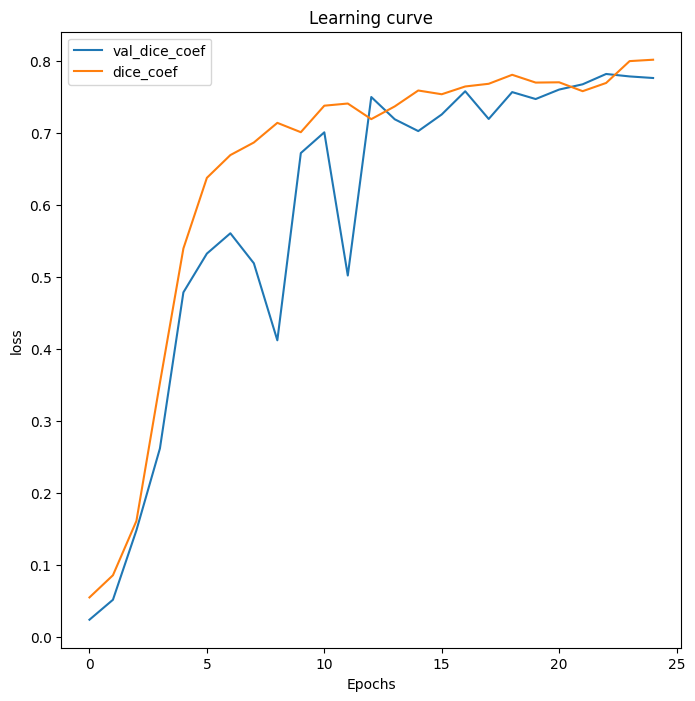

In [36]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
# plt.plot(results.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
# plt.plot(results.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot(results.history["dice_coef"], label="dice_coef")
# plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
# plt.grid(False)
plt.show()

In [37]:
# load the best modeleval_results = model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)
model.load_weights('model-brain-mri-dice-dice.h5')

In [38]:
eval_results = model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

61/61 [==============================] - 11s 174ms/step - loss: -0.7668 - dice_coef: 0.7676


1/1 [==============================] - 0s 23ms/step


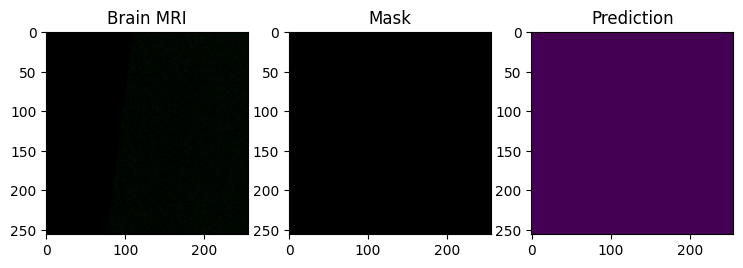

1/1 [==============================] - 0s 23ms/step


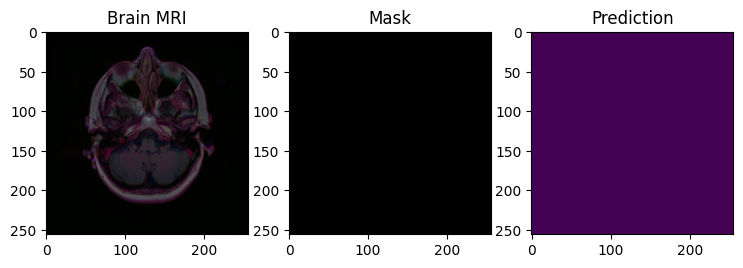

1/1 [==============================] - 0s 24ms/step


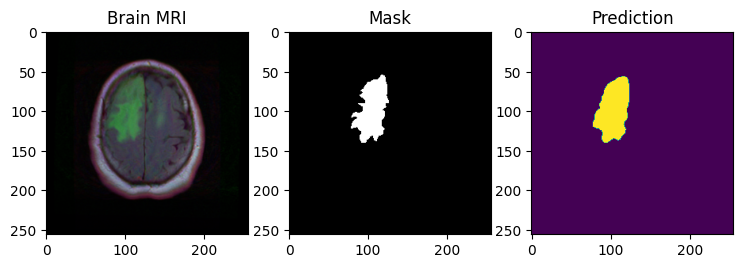

1/1 [==============================] - 0s 25ms/step


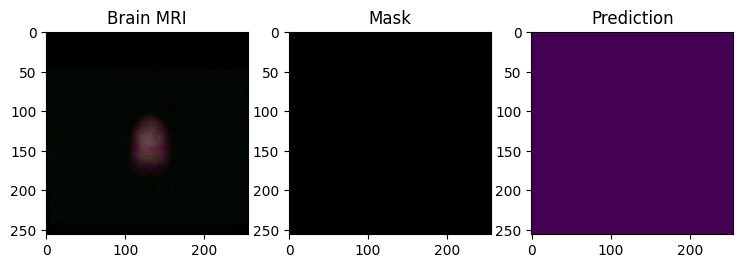

1/1 [==============================] - 0s 25ms/step


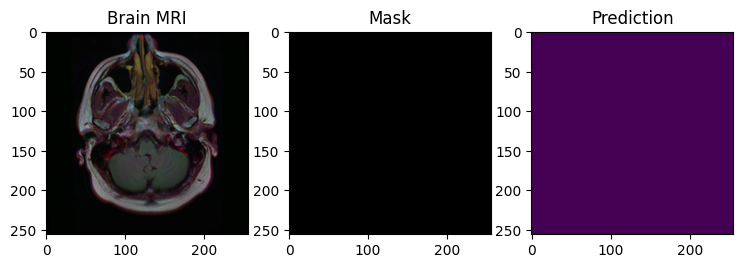

1/1 [==============================] - 0s 26ms/step


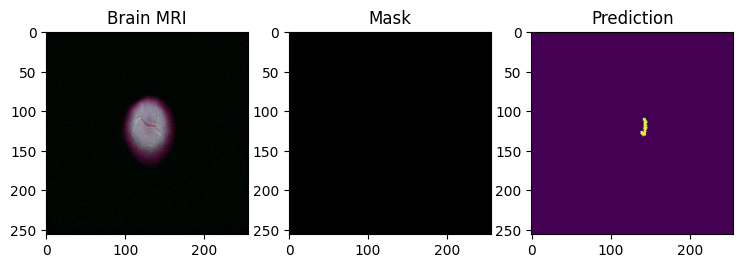

1/1 [==============================] - 0s 25ms/step


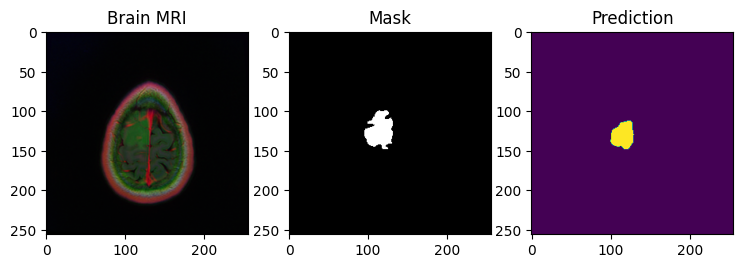

1/1 [==============================] - 0s 25ms/step


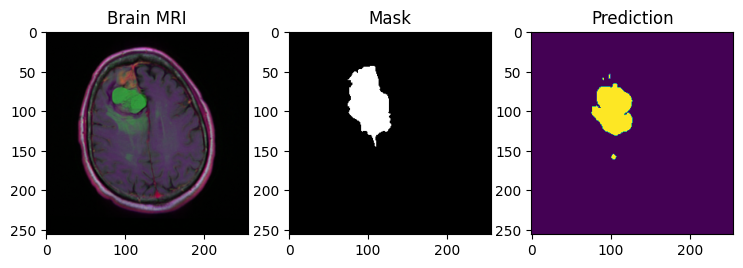

1/1 [==============================] - 0s 26ms/step


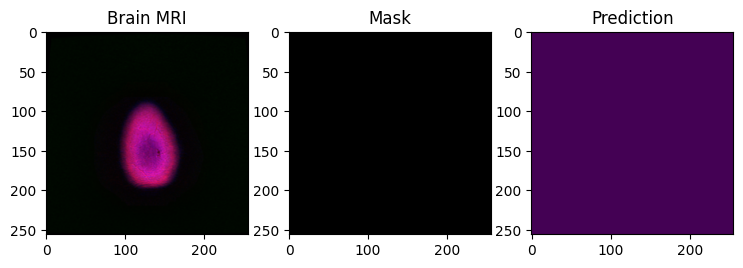

1/1 [==============================] - 0s 23ms/step


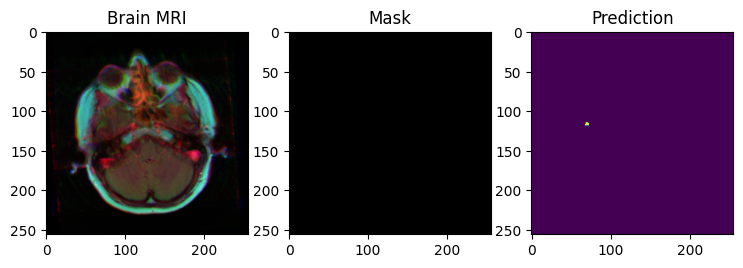

1/1 [==============================] - 0s 23ms/step


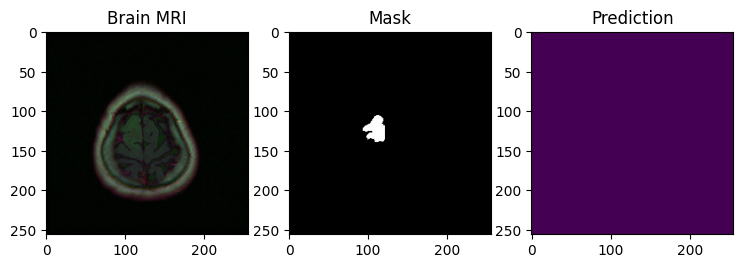

1/1 [==============================] - 0s 24ms/step


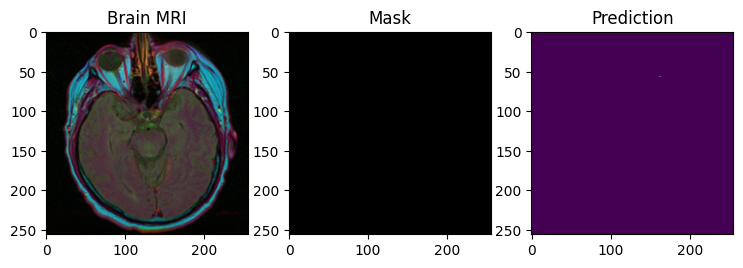

1/1 [==============================] - 0s 25ms/step


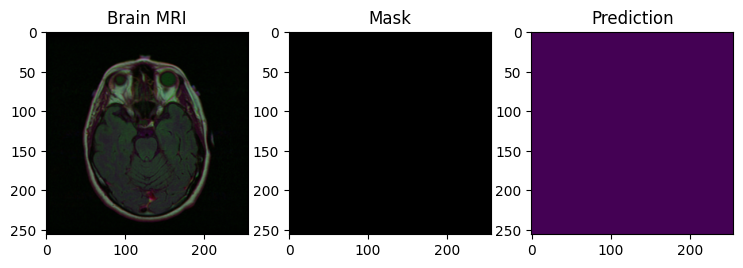

1/1 [==============================] - 0s 24ms/step


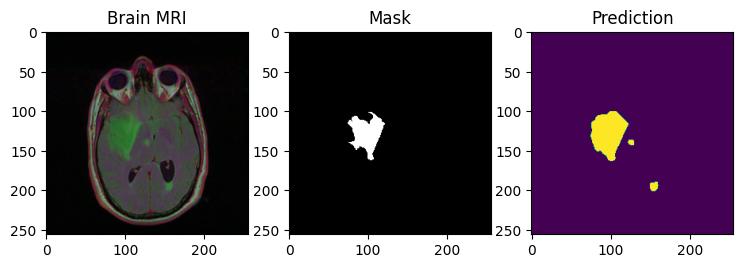

1/1 [==============================] - 0s 22ms/step


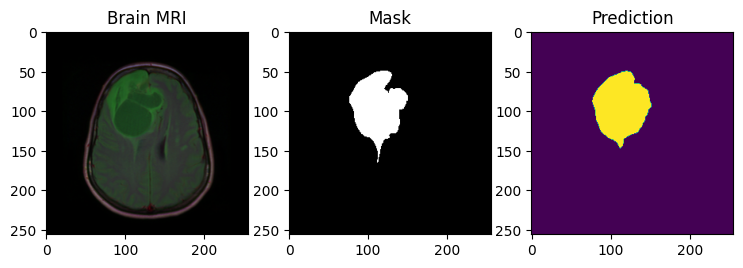

1/1 [==============================] - 0s 24ms/step


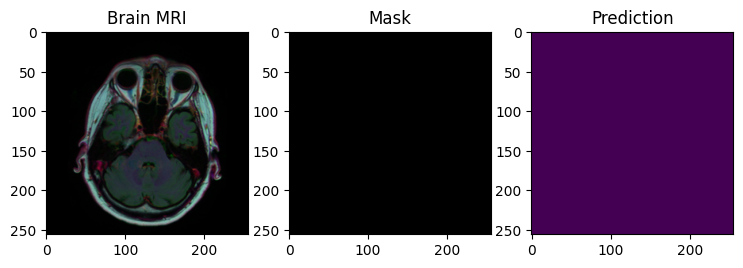

1/1 [==============================] - 0s 23ms/step


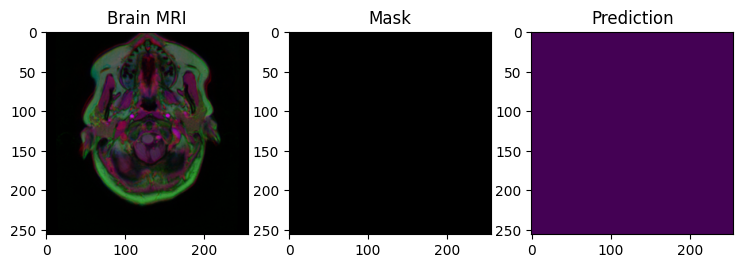

1/1 [==============================] - 0s 25ms/step


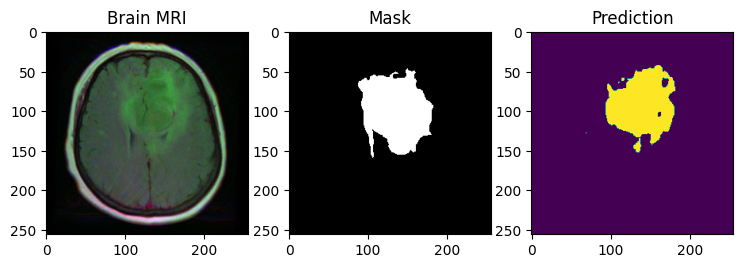

1/1 [==============================] - 0s 23ms/step


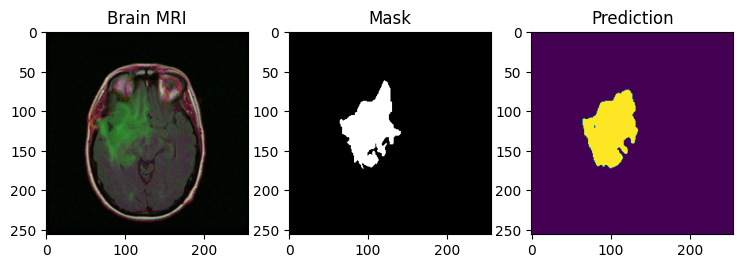

1/1 [==============================] - 0s 24ms/step


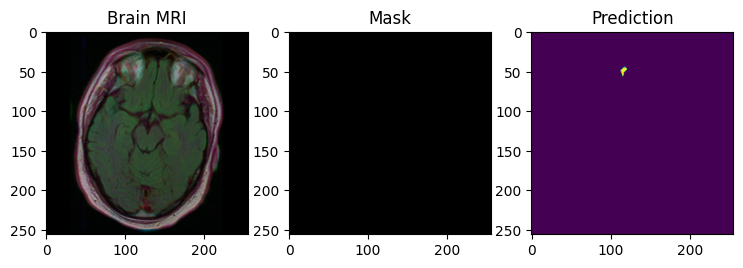

In [41]:
for i in range(20):
    idx = np.random.randint(0, len(df))
    
    imagePath = os.path.join(DataPath, df['directory'].iloc[idx], df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, df['directory'].iloc[idx], df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image ,(ImgHieght, ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Brain MRI')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('Prediction')
    plt.show()

In [48]:
model.save("/kaggle/working/model_dice.h5")